# DAML CP10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from math import factorial

## Problem \#1: The Frequentist method

In [13]:
# to make plot of ns vs nb curves
class Frequentist:
    
    def __init__(self, beta=0.05, N_obs=6, nb_max=15., ns_max=15.):
        # beta threshold from notes
        self.beta = beta
        # max values to scan recommended in notes
        self.nb_max = nb_max
        self.ns_max = ns_max
    
    # calculates beta value given equation 1 in notes
    def calc_beta(self, N_obs, nb, ns):
        mypois = poisson(nb + ns)
        sum_p = 0
        # include N_obs in sum
        for i in range(N_obs + 1):
            sum_p += mypois.pmf(i)
        return sum_p
    
    # find pairs of nb, ns within 0.005 of beta=0.05
    def find_close_pairs(self, N_obs, step):
        nbs = np.arange(0, self.nb_max, step)
        nss = np.arange(0, self.ns_max, step)
        # make array of all combinations
        pairs = np.array(np.meshgrid(nbs, nss)).T.reshape(-1, 2)
        close_pairs = []
        for i in range(len(pairs)):
            new_beta = self.calc_beta(N_obs, pairs[i][0], pairs[i][1])
            if abs(new_beta - self.beta) < 0.005:
                close_pairs.append(pairs[i])
        return close_pairs
    
    # make plots of ns vs. nb
    def plot_curves(self, N_obs, title):
        all_close_pairs = []
        N_obss = []
        # find close pairs for each N_obs
        for i in range(N_obs + 1):
            N_obss.append(i)
            all_close_pairs.append(self.find_close_pairs(i, 0.1))
        nb_lists = []
        ns_lists = []
        # drill into the nested lists to add nb's and ns's to separate lists for plotting
        for pair_list in all_close_pairs:
            nb_single_list = []
            ns_single_list = []
            for pair in pair_list:
                nb_single_list.append(pair[0])
                ns_single_list.append(pair[1])
            nb_lists.append(nb_single_list)
            ns_lists.append(ns_single_list)
        # plot
        fig, ax = plt.subplots()
        for i in range(len(nb_lists)):
            ax.plot(nb_lists[i], ns_lists[i], label=r'$N_{obs} = $' + str(i))
        ax.legend()
        ax.set_xlabel(r'$n_{b}$')
        ax.set_ylabel(r'$n^{upper}_{s}$', rotation=0, labelpad=20)
        # fix axis limits
        ax.set_xlim(0, self.nb_max)
        ax.set_ylim(0, self.ns_max) 
        ax.set_title(title)
        plt.show()

In [14]:
class Bayesian(Frequentist):
    
    # overwrite calc_beta now according to equation 4 from notes
    def calc_beta(self, N_obs, nb, ns):
        # break up expression for easier reading
        sum_numerator = 0
        sum_denominator = 0
        for i in range(N_obs + 1):
            sum_numerator += ((nb + ns)**i) / factorial(i)
            sum_denominator += (nb**i) / factorial(i)
        return np.exp(-ns) * (sum_numerator / sum_denominator)

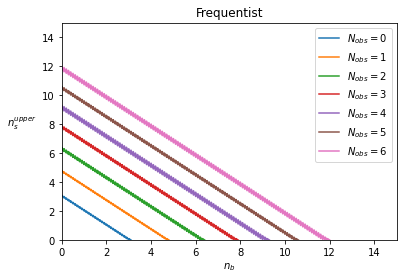

In [15]:
# frquentist plots
MyFreq = Frequentist()
N_obs = 6
MyFreq.plot_curves(N_obs, 'Frequentist')

We see that for $n_{b}=0$, $n^{upper}_{s}=3$ for $\beta=0.05$ as in lectures.

## Problem \#2: The Bayesian Method

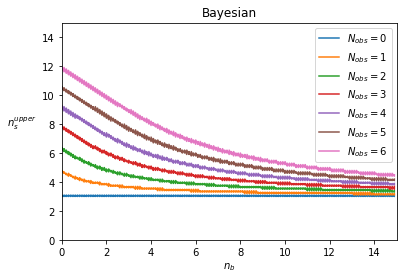

In [16]:
# reapeat for Bayesian class
MyBayes = Bayesian()
MyBayes.plot_curves(N_obs, 'Bayesian')

We see that apart from at $n_{b}=0$, $n^{upper}_{s}$ is greater than for the frequentist case for all $N_{obs}$ which means Bayesian upper limits are more conservative.

## Problem \#3: The CL$_{s}$ method

In [20]:
# calculate average number of events
def calc_avg_events(m, a, b):
    return a * np.exp(-b * m)

In [21]:
# given in notes
S = 7.
B = 14.
lambda_S = 1./600
lambda_B = 1./200

In [22]:
# mass range from notes
m_low = 100 # GeV/c^2
m_high = 600
mx = np.linspace(m_low, m_high, 100)

In [23]:
# calculate average 
ns_avg = calc_avg_events(mx, S, lambda_S)
nb_avg = calc_avg_events(mx, B, lambda_B)

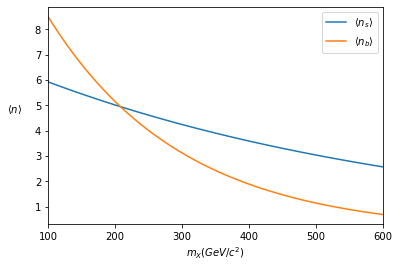

In [29]:
# plot averages for both ns and nb
fig, ax = plt.subplots()
ax.plot(mx, ns_avg, label=r'$\left \langle n_{s} \right \rangle$')
ax.plot(mx, nb_avg, label=r'$\left \langle n_{b} \right \rangle$')
ax.legend()
ax.set_xlabel(r'$m_{X}(GeV/c^{2})$')
ax.set_ylabel(r'$\left \langle n \right \rangle$', rotation=0, labelpad=20)
ax.set_xlim(m_low, m_high)
plt.show()

In [50]:
# return test statistics from a number of pseudo-experiments
def pseudo_exps_H1(m, num_exps):
    test_stat_array = np.zeros(num_exps)
    for i in range(len(test_stat_array)):
        ns_avg_m = calc_avg_events(m, S, lambda_S)
        nb_avg_m = calc_avg_events(m, B, lambda_B)
        # sample from Poisson distribution for H1
        n_events = np.random.poisson(ns_avg_m + nb_avg_m)
        # calculate likelihood values for both H1 and H0
        L_H1_poisson = poisson(ns_avg_m + nb_avg_m)
        L_H1 = L_H1_poisson.pmf(n_events)
        L_H0_poisson = poisson(nb_avg_m)
        L_H0 = L_H0_poisson.pmf(n_events)
        # formula from notes
        test_stat = -2 * np.log(L_H1 / L_H0)
        test_stat_array[i] = test_stat
    return test_stat_array

In [51]:
# exactly the same but for pseudo experiments for H0 model
def pseudo_exps_H0(m, num_exps):
    test_stat_array = np.zeros(num_exps)
    for i in range(len(test_stat_array)):
        ns_avg_m = calc_avg_events(m, S, lambda_S)
        nb_avg_m = calc_avg_events(m, B, lambda_B)
        n_events = np.random.poisson(nb_avg_m)
        L_H1_poisson = poisson(ns_avg_m + nb_avg_m)
        L_H1 = L_H1_poisson.pmf(n_events)
        L_H0_poisson = poisson(nb_avg_m)
        L_H0 = L_H0_poisson.pmf(n_events)
        test_stat = -2 * np.log(L_H1 / L_H0)
        test_stat_array[i] = test_stat
    return test_stat_array

In [52]:
num_exps = 2000
# start with mx=300
m1 = 300
ts_H1 = pseudo_exps_H1(m1, num_exps)
ts_H0 = pseudo_exps_H0(m1, num_exps)

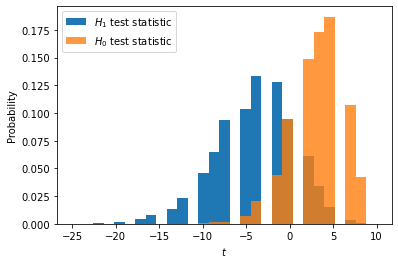

In [93]:
# make plot
fig, ax = plt.subplots()
# fix bins positions to be same for both to make next part easier
ts_H1_counts, ts_H1_bins, _ = ax.hist(ts_H1, bins=np.linspace(-25, 10, 30), density=True,
                                      label=r'$H_{1}$' + ' test statistic')
ts_H0_counts, ts_H0_bins, _ = ax.hist(ts_H0, bins=np.linspace(-25, 10, 30), density=True,
                                      label=r'$H_{0}$' + ' test statistic', alpha=0.8)
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_ylabel('Probability')
plt.show()

We see the overlap in distribution makes separating them more difficult. Therefore, CL$_{s}$ method may be useful.

In [80]:
# find index of bin with most counts
t_obs_idx = np.argmax(ts_H0_counts)
t_obs = ts_H0_bins[t_obs_idx]

In [84]:
# calculate CLx's defined in figure 1 in notes
# only use half of counts in t_obs bin
CL_sb = 0.5 * ts_H1_counts[t_obs_idx] + np.sum(ts_H1_counts[t_obs_idx + 1:])
CL_b = 0.5 * ts_H0_counts[t_obs_idx] + np.sum(ts_H0_counts[t_obs_idx + 1:])
CL_s = CL_sb / CL_b

In [89]:
# same process as above but without plots
def calc_t(m, num_exps):
    ts_H1 = pseudo_exps_H1(m, num_exps)
    ts_H0 = pseudo_exps_H0(m, num_exps)
    ts_H1_counts, ts_H1_bins = np.histogram(ts_H1, bins=np.linspace(-25, 10, 30), density=True)
    ts_H0_counts, ts_H0_bins = np.histogram(ts_H0, bins=np.linspace(-25, 10, 30), density=True)
    t_obs_idx = np.argmax(ts_H0_counts)
    t_obs = ts_H0_bins[t_obs_idx]
    CL_sb = 0.5 * ts_H1_counts[t_obs_idx] + np.sum(ts_H1_counts[t_obs_idx + 1:])
    CL_b = 0.5 * ts_H0_counts[t_obs_idx] + np.sum(ts_H0_counts[t_obs_idx + 1:])
    CL_s = CL_sb / CL_b
    return CL_s

In [90]:
full_ms = np.arange(m_low, m_high, 20)
CL_s_array = np.zeros(len(full_ms))
# calculate CL_s across mass spectrum
for i in range(len(CL_s_array)):
    CL_s_array[i] = calc_t(full_ms[i], num_exps)

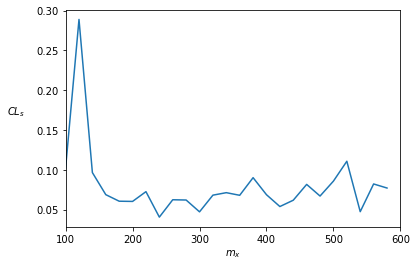

In [94]:
fig, ax = plt.subplots()
ax.plot(full_ms, CL_s_array)
ax.set_xlabel(r'$m_{x}$')
ax.set_ylabel(r'$CL_{s}$', rotation=0, labelpad=20)
ax.set_xlim(m_low, m_high)
plt.show()

Cannot reject H1 around $m_{x}=125$ GeV/c^2